# Foundational Concept
In Space Situational Awreness(SSA) and image is not a picture of ideal objects but a time integrated measurement of **photon flux** (number of photons passing through unit area in a unit time) on a discrete sensor grid. For every pixel x,y the recorded intensity is:
$$I(x,y)=\int_{0}^{T}\Phi(x(t),y(t))dt+n(x,y)$$
where T is exposure time, $\Phi$ is photon flus from stars/debis/objects and n(x,y) is the sensor noise (readout noise, dark current, shot noise) 

In [98]:
# Import necessary libraries
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from cv2 import medianBlur, fastNlMeansDenoising, getStructuringElement, morphologyEx, connectedComponentsWithStats, CC_STAT_AREA
from skimage import img_as_ubyte
from skimage.morphology import white_tophat, disk
from skimage.measure import label, regionprops

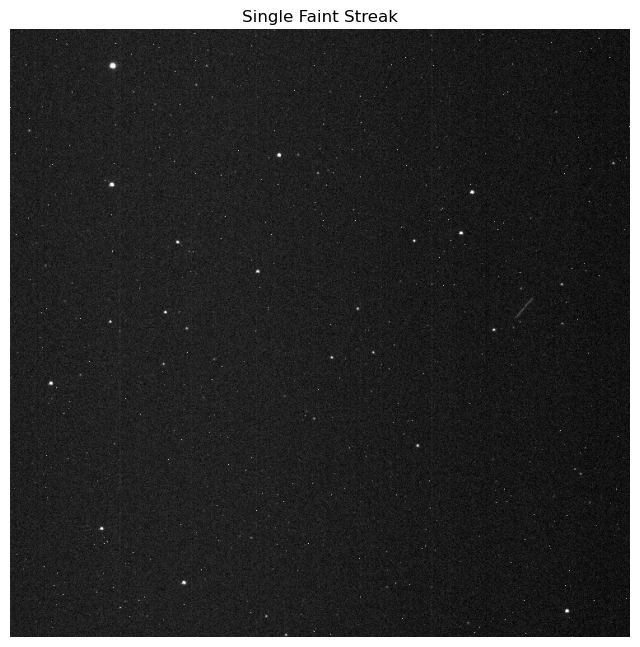

In [99]:
# Load the images
single_img = Image.open('single_faint_streak.jpg')
multi_img = Image.open('multiple_streaks.jpg')

# Visualize Single Faint Streak
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.imshow(single_img, cmap='gray')
axes.set_title('Single Faint Streak')
axes.axis('off')
plt.show()

# Streaks and Blobs
As stars are fixed point sources at astronimal distances its angular motion across the sensor during short exposure is negligible if the mount tracts the stars motion. The recorded signal is a PSF convolved with atmospheric and optical blur. The lines or streaks are satellites or objects which is convolition of PSF and motion path

As we can see the sky background is weak and nonzero and faint objects may have SNR close to 1. Also the sensor noise is not white or Gaussian by default. We might need to do preprocessing on this to transfer into a doimain where signal stats and noise stats are seperable.

Brightest pixel at (x=124, y=44) with value 255


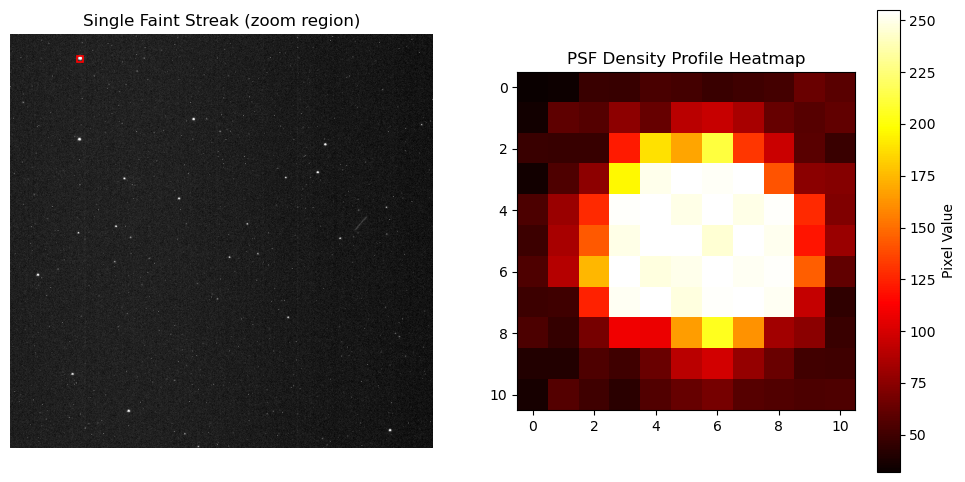

In [100]:
# convert to grayscale array and locate brightest pixel (PSF core)
img_arr = np.array(single_img.convert('L'))

#  for demonstration, we use fixed coordinates
y, x = 44, 124
print(f'Brightest pixel at (x={x}, y={y}) with value {img_arr[y, x]}')

# crop window around the point
half = 5
y0, y1 = max(0, y-half), min(img_arr.shape[0], y+half+1)
x0, x1 = max(0, x-half), min(img_arr.shape[1], x+half+1)
crop = img_arr[y0:y1, x0:x1]

# display full image with rectangle and zoomed PSF (asinh stretch to reveal faint wings)
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(img_arr, cmap='gray', origin='upper')
ax1.add_patch(Rectangle((x0, y0), x1-x0, y1-y0, edgecolor='red', facecolor='none', linewidth=1.2))
ax1.set_title('Single Faint Streak (zoom region)')
ax1.axis('off')

# Density profile heatmap
im = ax2.imshow(crop, cmap='hot', origin='upper', interpolation='nearest')
ax2.set_title('PSF Density Profile Heatmap')
plt.colorbar(im, ax=ax2, label='Pixel Value')
plt.show()

# Denoising without destroying the signal
The goal for denoising operation is to supress high-frequency noise, isolated hot pixels and minor background fluctuations while preserving elongated low contrast structures(faint streaks).
A naive Gaussian blur doesnot work as it reduces peak SNR of faint streaks instead denoising is used as variance reduction for signal preservation.
$$I(x,y)=S(x,y)+B(x,y)+n_r​(x,y)+n_d​(x,y)+n_s​(x,y)$$
S and B are desired signal(stars and streaks) and background(sky glow, gradients and vignetting). $n_r$ is readout noise (from electronics and gaussian type), $n_d$ is dark noise (temperature dependent) and $n_s$ is shot noise (poisson like variance grows with signal)

So we want to denoise means background becomes smooth (low variance), Stars remains compact (PSF is not smeared), Streaks remain continuous (not dotted) and Hot Pixels/outliers removed without deleting faint streak pixels

# A1: Denoise the raw image
We will be using a two step denoising one with median filter and other by Non Local Means (NLM) as edge preserving denoiser.

## 1. Remove Hot pixels using median filter
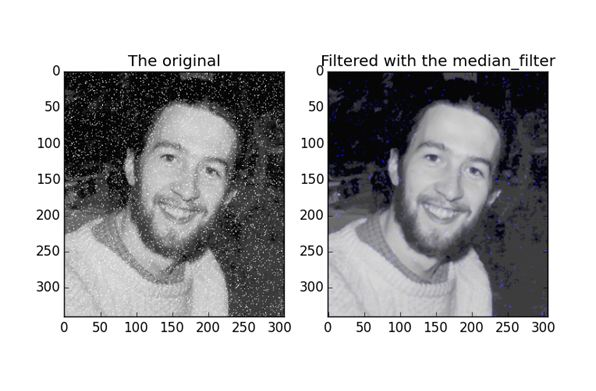 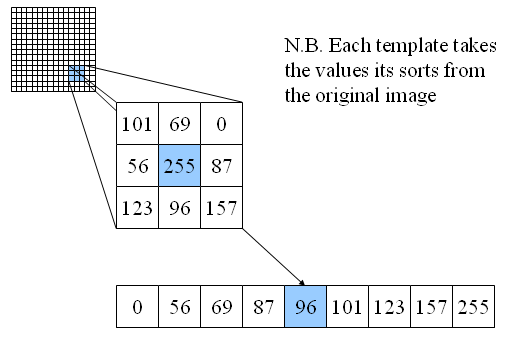
 
Median filter is ideal here cause it dampens single-pixel spike but keeps edges/lines better than Gaussian Blur. Each pixel is replace by the median of its local neighbourhood. If an isolated hot pixel becomes an extreme outlier median rejects it. Kernel size should be kept 3x3 or 5x5 if selected larger kernel it remove faint streaks.

## 2. Reduce fine grain using Non Local Means(NML)
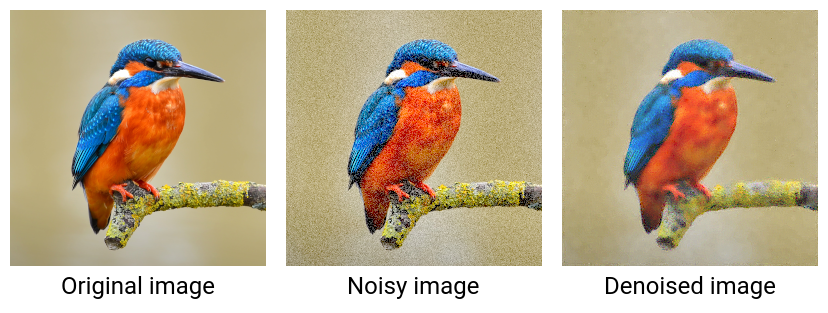 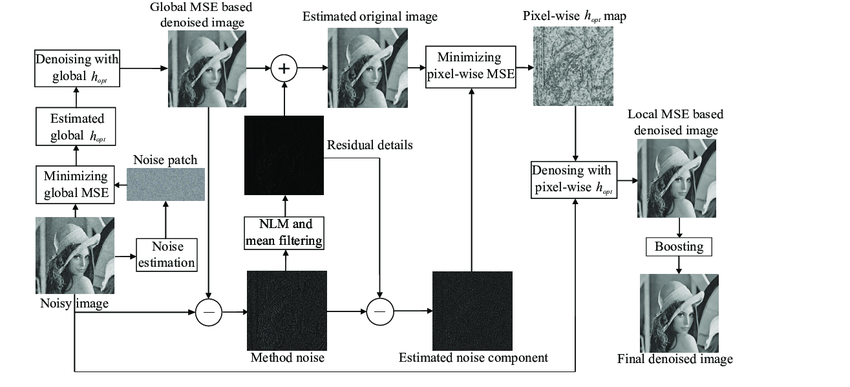


NLM Averages pixel that have similar neighbourhoods, even if they are far apart. It reduces stochastic noise strongly while keeping coherent structures more intact than Gaussian Blur. Patch size controls how local patterns are compared and search window finds how far it looks for similar patches.

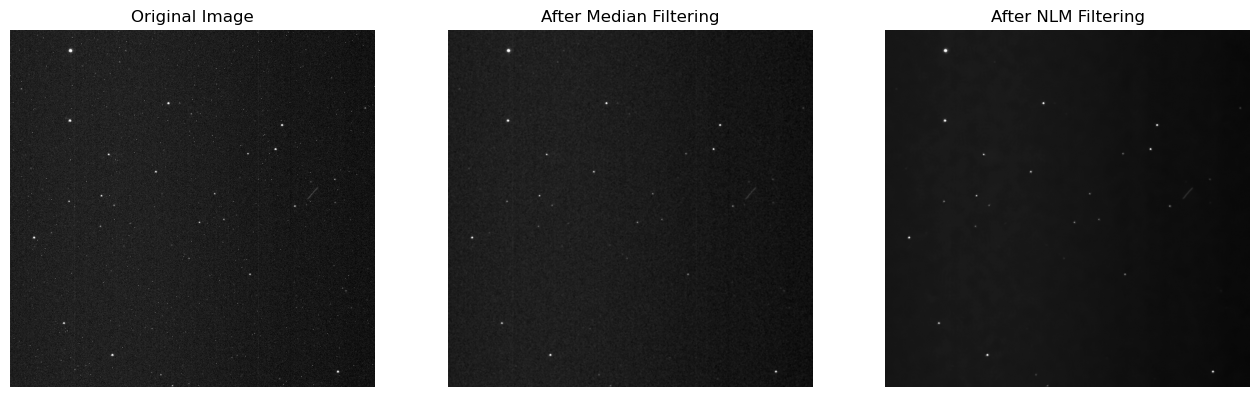

In [114]:
# Remove impulsive outliers (hot pixels) through median filtering
denoised_img1 = medianBlur(img_arr, ksize=3)

# Remove fine grain noise using NLM filtering
denoised_img2 = fastNlMeansDenoising(np.array(denoised_img1), None, h=7, templateWindowSize=7, searchWindowSize=21)

# Visualize side by side
cmap='gray'
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(img_arr, cmap=cmap)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(denoised_img1, cmap=cmap)
axes[1].set_title('After Median Filtering')
axes[1].axis('off')
axes[2].imshow(denoised_img2, cmap=cmap)
axes[2].set_title('After NLM Filtering')
axes[2].axis('off')
plt.show()

# A2: Enhance the denoised image to improve SNR
Denoising reduces the variance for noise but faint streaks can still be close to background. So we need to boost the detectibility of the signal. We want increased seperation between signal statistics and background statistics.

## 1. Remove low-frequency background (flatten)
SSA frame have often gradients like glow or vinetting if not removed any global thresholding will fail. We have to estivate background B(x,y) by a method that will ignore small bright features like Rolling ball Background subtraction. Which makes background zero mean and consistent. Then subtract the background from the denoised image.

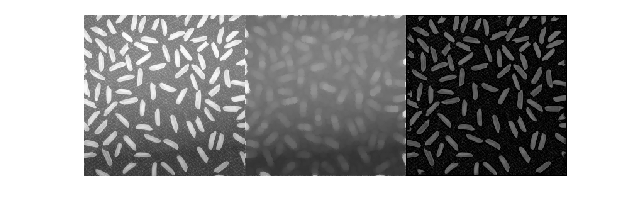

## 2. Matched filtering for enhancement of streaks
A faint streak is like a line like template. The best way to improve SNR is to correlate with something like a line. Using a multi-orientation line filter we convolve image with a thin line kernel at multiple angles. At correct angle streak pixels add constructively then background averages out. Output we get is a streakness response map. Then a morphological top-hat enhancement is done to amplify bright small and elongated features.

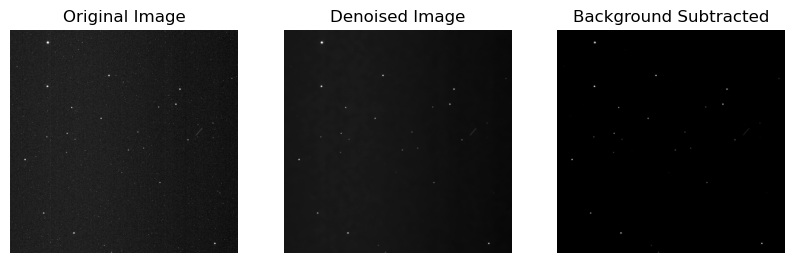

In [115]:
# Using Rolling Ball Algorithm for Background Subtraction
# Create a structuring element (disk) with a specified radius
selem = disk(4)

# Apply white tophat (rolling ball) to subtract background
background_subtracted = white_tophat(denoised_img2, selem)

# Visualize side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(img_arr, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(denoised_img2, cmap='gray')
axes[1].set_title('Denoised Image')
axes[1].axis('off')
axes[2].imshow(background_subtracted, cmap='gray')
axes[2].set_title('Background Subtracted')
axes[2].axis('off')
plt.show()

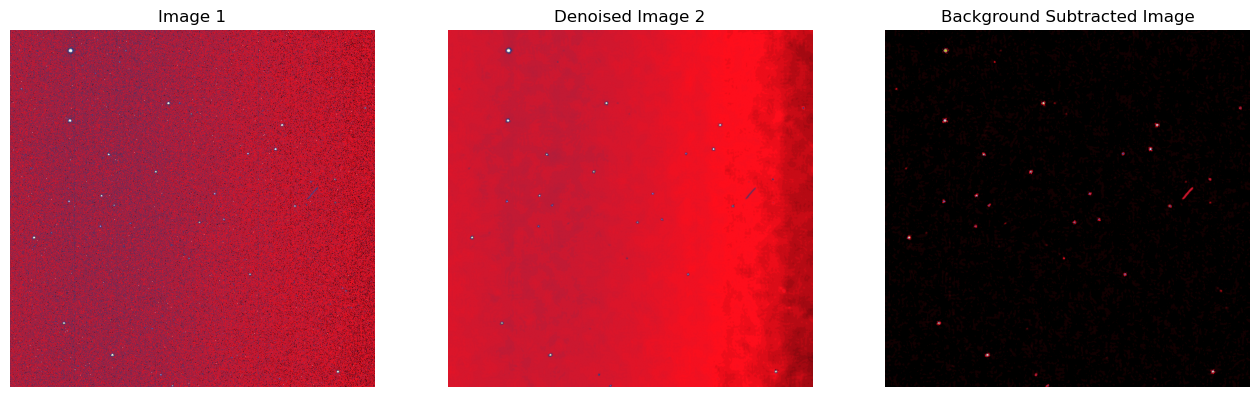

In [116]:
# Visualize Original and Background Subtracted Images Side by Side via diffence cmap
cmap = 'gist_stern'
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(img_arr, cmap=cmap)
axes[0].set_title('Image 1')
axes[0].axis('off')

axes[1].imshow(denoised_img2, cmap=cmap)
axes[1].set_title('Denoised Image 2')
axes[1].axis('off')

axes[2].imshow(background_subtracted, cmap=cmap)
axes[2].set_title('Background Subtracted Image')
axes[2].axis('off')
plt.show()

# Thresholding to Enhance image to Isolate Bright pixels
We will now threshold the image not on original image intensity but where in image background is flatter and streaks/stars are amplified. Good way to thresholding is to estimate background mean or median and dispersion from the enhanced image. set threshold = mean of enhanced image + k * std of enhanced image.

(np.float64(-0.5), np.float64(752.5), np.float64(737.5), np.float64(-0.5))

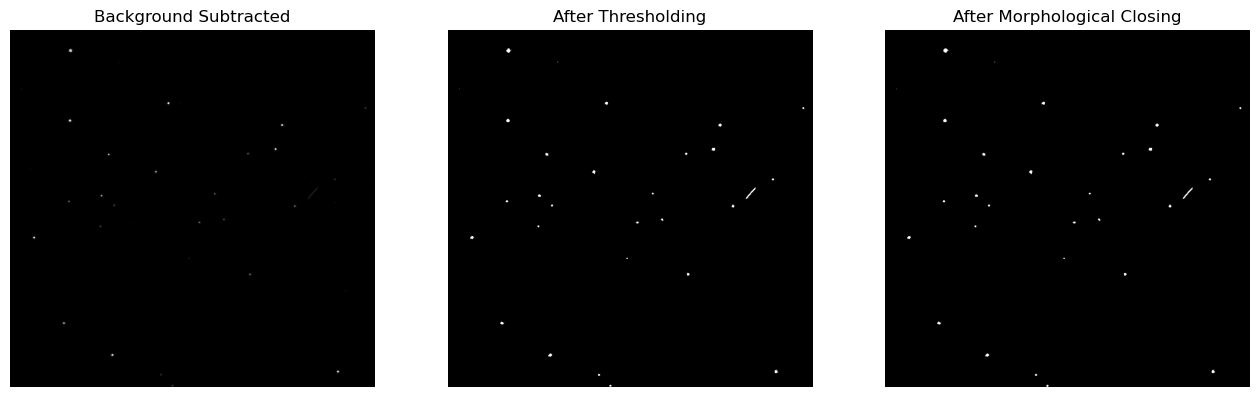

In [122]:
import cv2

# Thresholding to create binary mask
mu = np.mean(background_subtracted)
sigma = np.std(background_subtracted)

threshold = mu + 4 * sigma
mask = (background_subtracted > threshold).astype(np.uint8)

# Small cleanuop using morphological operations
kernel = getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
closed_mask = morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=7)

# Visualize side by side
cmap='gray'
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(background_subtracted, cmap=cmap)
axes[0].set_title('Background Subtracted')
axes[0].axis('off')
axes[1].imshow(mask, cmap=cmap)
axes[1].set_title('After Thresholding')
axes[1].axis('off')
axes[2].imshow(closed_mask, cmap=cmap)
axes[2].set_title('After Morphological Closing')
axes[2].axis('off')

(np.float64(-0.5), np.float64(752.5), np.float64(737.5), np.float64(-0.5))

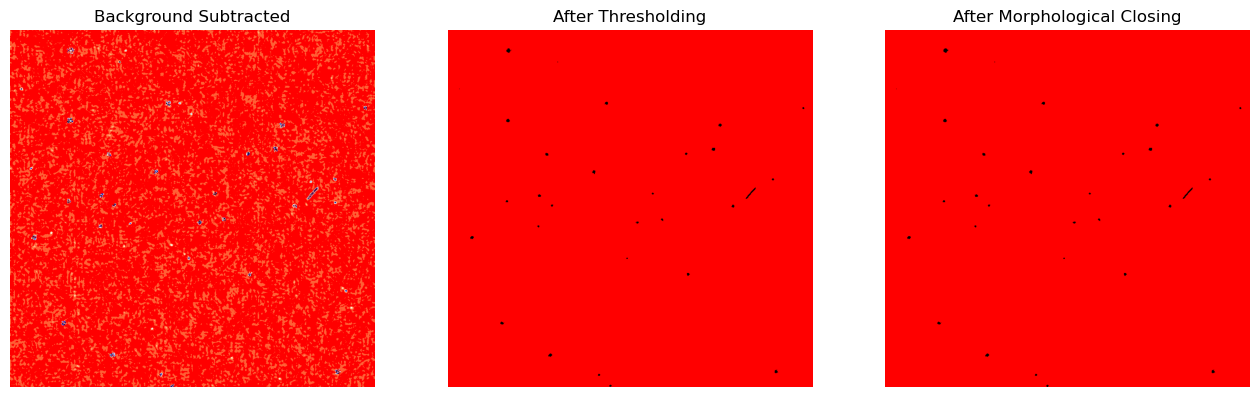

In [123]:
# Visualize side by side with different colormap
cmap='flag'
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(background_subtracted, cmap=cmap)
axes[0].set_title('Background Subtracted')
axes[0].axis('off')
axes[1].imshow(mask, cmap=cmap)
axes[1].set_title('After Thresholding')
axes[1].axis('off')
axes[2].imshow(closed_mask, cmap=cmap)
axes[2].set_title('After Morphological Closing')
axes[2].axis('off')

# Detect Stars and Streaks and compute subpixel centroids
In this step we label connected region in binary mask then for each region we compute shape properties. A classical way is to find covariance of pixel coordinates weighted by pixel intensity. $$\Sigma = \begin{bmatrix}\mu_{20} & \mu_{11}\\\mu_{11} & \mu_{02}\end{bmatrix}$$
Eignevalues $\lambda_1$ >= $\lambda_2$ give elongation. Stars elongation near 1 roughly circular and streaks large elongation.

To find subpixel centroids we do intesity weighted centroid due to PSF distribution.
$$
\bar{x} = \frac{\sum xI(x,y)}{\sum I(x, y_i)}
$$
$$
\bar{y} = \frac{\sum yI(x,y)}{\sum I(x,y)}
$$

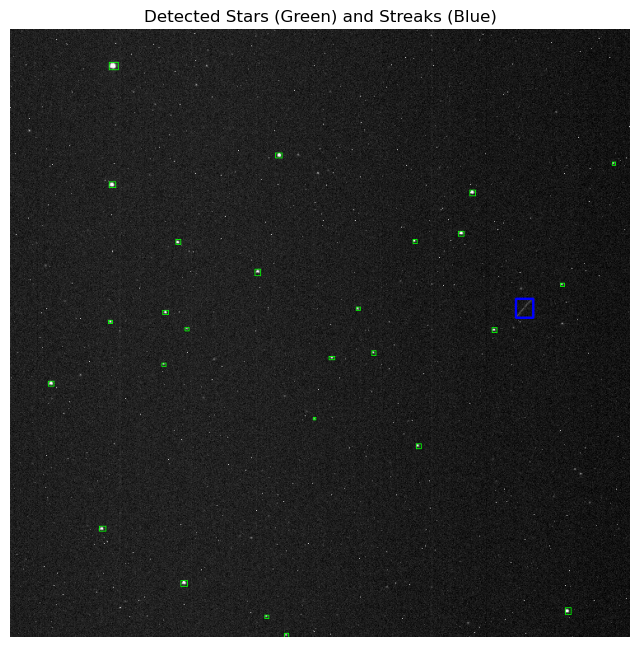

In [125]:
# Label connected components
num_labels, labels_im, stats, centroids = connectedComponentsWithStats(closed_mask, connectivity=8)

# Classify as star vs streak using covariance matrix analysis and eigenvalues and aspect ratio
stars = []
streaks = []
for label in range(1, num_labels):  # Skip background label 0
    area = stats[label, CC_STAT_AREA]
    if area < 5:
        continue  # Ignore very small components

    # Extract pixel coordinates for the current component
    coords = np.column_stack(np.where(labels_im == label))

    # Compute covariance matrix and eigenvalues
    cov = np.cov(coords, rowvar=False)
    eigvals, eigvecs = np.linalg.eig(cov)

    # Sort eigenvalues
    eigvals = np.sort(eigvals)[::-1]  # Descending order

    # Compute elongation ratio
    epsilon = 1e-5
    if eigvals[1] == 0:
        elongation = float('inf')
    else:
        elongation = eigvals[0] / eigvals[1] + epsilon

    # Compute eccentricity for robustness
    if eigvals[0] > 0:
        eccentricity = np.sqrt(1 - (eigvals[1] / eigvals[0])**2)
    else:
        eccentricity = 1.0

    # Classify based on elongation and eccentricity
    x, y, w, h = stats[label, cv2.CC_STAT_LEFT], stats[label, cv2.CC_STAT_TOP], stats[label, cv2.CC_STAT_WIDTH], stats[label, cv2.CC_STAT_HEIGHT]
    if elongation < 25 and eccentricity < 1:
        stars.append((x, y, w, h, area))
    else:
        streaks.append((x, y, w, h, area))



# Adding bounding boxes to detected stars and streaks
annotated_img = cv2.cvtColor(img_as_ubyte(single_img), cv2.COLOR_GRAY2BGR)
for star in stars:
    x, y, w, h, area = star
    cv2.rectangle(annotated_img, (x, y), (x + w, y + h), (0, 255, 0), 1)  # Green for stars
for streak in streaks:
    x, y, w, h, area = streak
    cv2.rectangle(annotated_img, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Blue for streaks
# Visualize the annotated image
plt.figure(figsize=(8, 8))
plt.imshow(annotated_img)
plt.title('Detected Stars (Green) and Streaks (Blue)')
plt.axis('off')
plt.show()


In [126]:
# Adding centroid location outputting it to CSV file for both streaks and stars
centroid_data = []
for streak in streaks:
    x, y, w, h, area = streak
    cx = x + w / 2
    cy = y + h / 2
    centroid_data.append({'Type': 'Streak', 'Centroid_X': cx, 'Centroid_Y': cy})
for star in stars:
    x, y, w, h, area = star
    cx = x + w / 2
    cy = y + h / 2
    centroid_data.append({'Type': 'Star', 'Centroid_X': cx, 'Centroid_Y': cy})
df = pd.DataFrame(centroid_data)
df.to_csv('single_faint_centroids.csv', index=False)
print('Centroid data saved to single_faint_centroids.csv')

Centroid data saved to single_faint_centroids.csv
